# Measuring cell-cell interactions

Want to use a G-function to estimate distance relationships. Helpful resources:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html#scipy.spatial.cKDTree
https://stackoverflow.com/questions/52366421/how-to-do-n-d-distance-and-nearest-neighbor-calculations-on-numpy-arrays
https://stackoverflow.com/questions/15792552/numpy-scipy-equivalent-of-r-ecdfxx-function
https://geographicdata.science/book/notebooks/09_spatial_inequality.html
https://pysal.org/notebooks/explore/pointpats/distance_statistics.html

interactions of interest:
    - M2-CD8
    - macrophage-CD8
   
interactions may be particularly important in KFD

To make the G-function plot:
    1. Cell-cell distances with scipy cKDTree
    2. plot with eCDF (from statsmodels); create normal gaussian CDF using data
    3. Test other sample distance distributions with Kolmogorov–Smirnov test



In [1]:
import anndata as ad
import numpy as np
import pandas as pd
import scanpy as sc
import scipy as sci
import seaborn as sns; sns.set(color_codes=True)
import matplotlib.pyplot as plt
# Import Scimap
import scimap as sm
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import poisson
import math

/mnt/isilon/cscb/software/anaconda3/envs/scimap/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [45]:
adata = sc.read_h5ad('/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/simple_h5ad/K1_reg1_statistics_growth5_comp.h5ad')
pred = pd.read_csv('/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/simple_h5ad/K1_reg1_statistics_growth5_comp_pred.csv')
adata.obs = pred

In [2]:
adata = sc.read_h5ad('/mnt/isilon/cscb/codex/pillaiv/SCTC-VP-15/outs/neighborhood_analysis/MCD1/dat.h5ad')


In [3]:
adata.obs.head()

,Unnamed: 0,orig.ident,nCount_originalexp,nFeature_originalexp,Reg,Tile.Row,Tile.Col,Tile.Z,In.Tile.Y,In.Tile.X,Absolute.Y,Absolute.X,Cell.Size,n_genes_by_counts,total_counts,nCount_raw,nFeature_raw,cell_type_pred_knn,cell_type_pred_knn_prob
0,1.0,SeuratProject,2.909424,21,0,1,1,0,376.634361,679.563877,376.634361,679.563877,522,44,833.986572,10000.000044,44,Macrophage_MPO+,0.6
1,2.0,SeuratProject,11.028535,22,0,1,1,0,700.220588,800.654412,700.220588,800.654412,393,44,292.699646,9999.999979,44,B_Cell,1.0
2,3.0,SeuratProject,5.029058,21,0,1,1,0,555.238754,709.249135,555.238754,709.249135,624,44,480.421478,9999.999809,44,Macrophage,0.6
3,4.0,SeuratProject,6.842954,22,0,1,1,0,125.716377,673.487649,125.716377,673.487649,1688,44,404.855408,10000.001004,44,FDC,1.0
4,5.0,SeuratProject,0.584977,18,0,1,1,0,692.337662,675.136364,692.337662,675.136364,429,44,372.163177,9999.999763,44,Macrophage,0.6


In [7]:
adata.obs.cell_type_pred_knn.value_counts()

CD4_T_Cell          118265
B_Cell               75395
Endothelial          38689
Macrophage           38640
Endothelial_MCD1     36562
FDC                  26527
CD8_T_Cell           26051
pDC                  20609
Plasma_Cell          18201
unknown              17474
Sinus_histiocyte     14370
Plasma_prolif        10818
cDC1                  7166
Macrophage_MPO+       5625
Neutrophil            3786
B_Cell_germ           3050
cDC2                  2401
Tfh                   1359
activated_T_Cell      1334
Lymphatics            1194
Treg                   715
Cytotoxic_T_Cell       292
Macrophage_M2          240
Mast_Cell                8
Name: cell_type_pred_knn, dtype: int64

## Distance measurement
Using CD8 as baseline bc there were less cells

For the Complete spatial randomness (CSR), the CDF is calculated as a poisson distribution. mu = # total cells
https://en.wikipedia.org/wiki/Complete_spatial_randomness


In [3]:
def single_csr(V, p, r):
    density = p/V
    probs = 2*(density*math.pi)*(r**2)*math.exp(-density*(r**2))
    return probs
make_csr = np.vectorize(single_csr)

In [4]:
def cc_dist(ad, c1, c2):
    ref_dat = ad.obs.loc[ad.obs['cell_type_pred_knn']==c1, ['Absolute.Y', 'Absolute.X']]
    q_dat = ad.obs.loc[ad.obs['cell_type_pred_knn']==c2, ['Absolute.Y', 'Absolute.X']]
    ref_tree = sci.spatial.cKDTree(ref_dat)
    dist_res = ref_tree.query(q_dat, k=1)
    ecdf = ECDF(dist_res[0])
    return(ecdf)

In [12]:
def simdata(adata, ref_dat, q_dat, ecdf):
    y = np.ptp(adata.obs['Absolute.Y'])
    x = np.ptp(adata.obs['Absolute.X'])
    area = y*x
    events = ref_dat.shape[0] + q_dat.shape[0]
    dist = np.arange(1,np.floor(ecdf.x.max()), 5)
    csr_prob = make_csr(area, events, dist)
    csr_prob = csr_prob/csr_prob.sum()
    csr_cdf = np.array(list(map(lambda x: csr_prob[0:x].sum(), np.arange(len(dist)))))
    return (dist, csr_cdf)

In [8]:
ref_dat = adata.obs.loc[adata.obs['cell_type_pred_knn']=='Endothelial', ['Absolute.Y', 'Absolute.X']]
q_dat = adata.obs.loc[adata.obs['cell_type_pred_knn']=='CD8_T_Cell', ['Absolute.Y', 'Absolute.X']]
# ref_dat = adata.obs.loc[adata.obs['cell_type_pred_knn']=='Macrophage_M2', ['Absolute.Y', 'Absolute.X']]
# q_dat = adata.obs.loc[adata.obs['cell_type_pred_knn']=='CD8_T_Cell', ['Absolute.Y', 'Absolute.X']]
print(ref_dat.shape)

(38689, 2)


In [9]:
ref_tree = sci.spatial.cKDTree(ref_dat)

In [10]:
# find 1-K nearest neighbors

dist_res = ref_tree.query(q_dat, k=1)
ecdf = ECDF(dist_res[0])
type(dist_res)

tuple

In [16]:
# # making the CSR
# y = np.ptp(adata.obs['Absolute.Y'])
# x = np.ptp(adata.obs['Absolute.X'])
# area = y*x
# events = ref_dat.shape[0] + q_dat.shape[0]
# dist = np.arange(1,np.floor(ecdf.x.max()), 5)
# csr_prob = make_csr(area, events, dist)
# csr_prob = csr_prob/csr_prob.sum()
# csr_cdf = np.array(list(map(lambda x: csr_prob[0:x].sum(), np.arange(len(dist)))))
csr_dat = simdata(adata, ref_dat, q_dat, ecdf)

In [36]:
q_dat.shape

(26051, 2)

In [41]:
df = pd.DataFrame(csr_dat).T
pd.concat([df, pd.Series(ecdf(csr_dat[0]))], axis=1)

,0,1,0
0,1.0,0.000000,0.000499
1,6.0,0.000201,0.022801
2,11.0,0.007271,0.076427
3,16.0,0.029694,0.176231
4,21.0,0.072958,0.307397
5,26.0,0.138645,0.439676
6,31.0,0.224412,0.558059
7,36.0,0.324782,0.665157
8,41.0,0.432471,0.756439
9,46.0,0.539868,0.826725


In [40]:
ecdf(csr_dat[0])

array([4.99021151e-04, 2.28014280e-02, 7.64270086e-02, 1.76231239e-01,
       3.07397029e-01, 4.39676020e-01, 5.58059192e-01, 6.65156808e-01,
       7.56439292e-01, 8.26724502e-01, 8.79275268e-01, 9.18314076e-01,
       9.47295689e-01, 9.65874631e-01, 9.78426932e-01, 9.86526429e-01,
       9.91555027e-01, 9.94856244e-01, 9.97005873e-01, 9.98119074e-01,
       9.98848413e-01, 9.99270661e-01, 9.99692910e-01, 9.99846455e-01,
       9.99884841e-01, 9.99923228e-01, 9.99961614e-01])

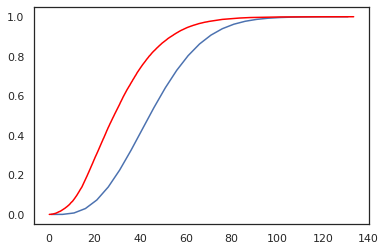

In [38]:
plt.plot(csr_dat[0], csr_dat[1])
plt.plot(ecdf.x, ecdf.y, c='red')
plt.show()

In [13]:
adata.obs.columns

Index(['Unnamed: 0', 'orig.ident', 'nCount_originalexp',
       'nFeature_originalexp', 'Reg', 'Tile.Row', 'Tile.Col', 'Tile.Z',
       'In.Tile.Y', 'In.Tile.X', 'Absolute.Y', 'Absolute.X', 'Cell.Size',
       'n_genes_by_counts', 'total_counts', 'nCount_raw', 'nFeature_raw',
       'cell_type_pred_knn', 'cell_type_pred_knn_prob', 'motif', 'index_info',
       'region'],
      dtype='object')

In [47]:
df.shape

(48, 3)

In [48]:
dat_dict = {}
for r in adata.obs.region.unique():
    adata_sub = adata.obs.loc[adata.obs.region == r,:].copy()
    ref_dat = adata_sub.loc[adata_sub['cell_type_pred_knn']=='Endothelial', ['Absolute.Y', 'Absolute.X']]
    q_dat = adata_sub.loc[adata_sub['cell_type_pred_knn']=='CD8_T_Cell', ['Absolute.Y', 'Absolute.X']]
    ref_tree = sci.spatial.cKDTree(ref_dat)
    dist_res = ref_tree.query(q_dat, k=1)
    ecdf = ECDF(dist_res[0])
    csr_dat = pd.DataFrame(simdata(adata, ref_dat, q_dat, ecdf)).T
    df = pd.concat([csr_dat, pd.Series(ecdf(csr_dat[0]))], axis=1)
    df.columns = ['dist', 'csr', 'ecdf']
    dat_dict[r] = df

In [51]:
for r, df in dat_dict.items():
    if r == '0':
        merge_df = df
    else:
        merge_df = merge_df.join(df, rsuffix=r)
merge_df.head()

,dist,csr,ecdf,dist1,csr1,ecdf1
0,1.0,0.000000,0.000000,1.0,0.000000,0.000000
1,6.0,0.000065,0.000000,6.0,0.000077,0.000000
2,11.0,0.002387,0.003768,11.0,0.002822,0.002617
3,16.0,0.009980,0.043689,16.0,0.011770,0.038849
4,21.0,0.025360,0.123352,21.0,0.029801,0.114198


In [55]:
merge_df['ecdf_avg'] = merge_df.filter(regex='ecdf').apply(np.mean, axis=1)
merge_df['csr_avg'] = merge_df.filter(regex='csr').apply(np.mean, axis=1)

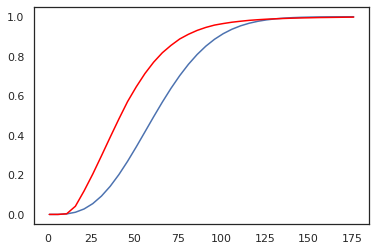

In [56]:
plt.plot(merge_df['dist'], merge_df['csr_avg'])
plt.plot(merge_df['dist'], merge_df['ecdf_avg'], c='red')
plt.show()